In [1]:
import cv2

src1 = cv2.imread('/home/megu/ECoG_CNNs/Result/MK18_expt.0/original_image.png')
src2 = cv2.imread('/home/megu/ECoG_CNNs/Result/MK18_expt.0/smoothGrad.png')

dst = cv2.addWeighted(src1, 0.5, src2, 0.5, 0)

cv2.imwrite('/home/megu/ECoG_CNNs/Result/MK18_expt.0/opencv_add_weighted.jpg', dst)

True

In [2]:
import numpy as np
from PIL import Image

src1 = np.array(Image.open('/home/megu/ECoG_CNNs/motoImage.png'))
src2 = np.array(Image.open('/home/megu/ECoG_CNNs/smoothGrad_testimage.png'))

print(src1.dtype)
# uint8

dst = src1 * 0.5 + src2 * 0.5

print(dst.dtype)
# float64

Image.fromarray(dst.astype(np.uint8)).save('home/megu/ECoG_CNNs/numpy_image_alpha_blend.jpg')

uint8


ValueError: operands could not be broadcast together with shapes (224,224,4) (224,224) 

In [1]:
from pathlib import Path

import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

class MyDataset(data.Dataset):
    def __init__(self, dir_path, input_size):
        super().__init__()

        self.dir_path = dir_path
        self.input_size = input_size

        self.image_paths = [str(p) for p in Path(self.dir_path).glob("**/*.png")]
        self.len = len(self.image_paths)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        p = self.image_paths[index]

        # 入力
        image = Image.open(p)
        image = image.resize(self.input_size)
        image = np.array(image)
        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image).float()

        # ラベル (0: EyesClosed, 1: Anesthetized)
        label = p.split("/")[6]     #ここはpath名が変わると変更することになるので、いつかうまい具合に書き換える
        label = 1 if label == "Anesthetized" else 0

        return image, label

def pytorch_book(data_dir):
    test_transform = transforms.Compose([
        transforms.Resize(224),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize(0.5, 0.5)
    ])

    # 訓練データ用: 正規化に追加で反転とRandomErasingを実施
    train_transform = transforms.Compose([
        transforms.Resize(224),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize(0.5, 0.5),
        #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
    ])


    # ツリーのベースディレクトリ
    #data_dir = '/home/megu/CNN_Dataset/MK3_expt.1'

    # 訓練データディレクトリと検証データディレクトリの指定
    import os
    train_dir = os.path.join(data_dir, 'train')
    test_dir = os.path.join(data_dir, 'test')

    # join関数の結果確認
    print(train_dir, test_dir)

    # 分類先クラスのリスト作成
    classes = ['EyesClosed', 'Anesthetized']

    trainval_dataset = datasets.ImageFolder(train_dir,
                        transform=train_transform)

    return trainval_dataset

In [5]:
debug_dataset = pytorch_book('/home/megu/CNN_Dataset/MK3_expt.1')

/home/megu/CNN_Dataset/MK3_expt.1/train /home/megu/CNN_Dataset/MK3_expt.1/test


In [6]:
# データ件数確認

print(f'訓練データ: {len(debug_dataset)}件')
#print(f'検証データ: {len(test_data)}件')

訓練データ: 6028件


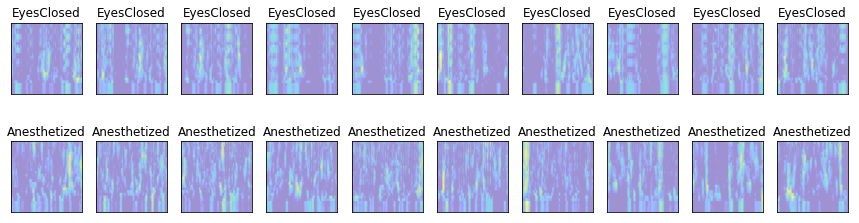

In [7]:
# 検証データ　
# 最初の10個と最後の10個の表示
import matplotlib.pyplot as plt

classes = ['EyesClosed', 'Anesthetized']

plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    image, label = debug_dataset[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = debug_dataset[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [1]:
import datetime
import os

import numpy as np
import torch
import torch.optim as optim
import torch.utils.data
import torch.nn as nn
from sklearn.model_selection import KFold
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from statistics import mean
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


import model
import dataset
import graph
from parameters import Parameters1, Parameters2
import graph

In [3]:


parameter=Parameters1

# make result dir
os.makedirs(parameter.RESULT_DIR_PATH, exist_ok=True)

#load Dataset
#trainval_dataset = dataset.MyDataset(parameter.TRAIN_DATASET_PATH + "/train", (parameter.RESIZE[0], parameter.RESIZE[1]))    #画像のリサイズはいくらにするか？　これは学習とテストに影響を与える

#trainval_dataset = dataset.pytorch_book(parameter.TRAIN_DATASET_PATH)
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])
train_dir = os.path.join(parameter.TRAIN_DATASET_PATH, 'train')
trainval_dataset = datasets.ImageFolder(train_dir,
                    transform=train_transform)

print(len(trainval_dataset))

6028


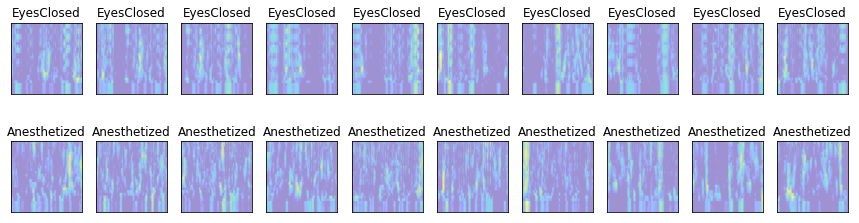

In [6]:
import matplotlib.pyplot as plt

classes = ['EyesClosed', 'Anesthetized']

plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    image, label = trainval_dataset[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = trainval_dataset[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


In [9]:
nets, accs, losses = [], [], []


device = torch.device(parameter.DEVICE)

criterion = nn.CrossEntropyLoss()


splits = KFold(n_splits=5, shuffle=True, random_state=26)   # random_stateの値は要検討
for fold, (train_idx, val_idx) in enumerate(splits.split(trainval_dataset)):
    file_path = parameter.RESULT_DIR_PATH + "/" + parameter.EXPT_NUMBER + '.log'
    with open(file_path, 'a') as f:
        print("model name: model", fold + 1, file=f)

    #net = model.CNNs(p_dropout1=0.25, p_dropout2=0.5, use_Barch_Norm=False).to(device)
    #optimizer = optim.SGD(net.parameters(),lr=parameter.LEARNING_RATE, momentum=0.9, weight_decay=parameter.WEIGHT_DECAY)   #Adams検討

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_dataloader = torch.utils.data.DataLoader(
        trainval_dataset, batch_size=parameter.TRAIN_BATCH_SIZE,
        sampler=train_sampler, num_workers=2, drop_last=True
    )
    val_dataloader = torch.utils.data.DataLoader(
        trainval_dataset, batch_size=parameter.TRAIN_BATCH_SIZE,
        sampler=val_sampler, num_workers=2, drop_last=True
    )

In [12]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()


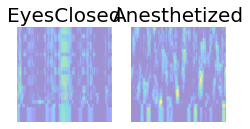

In [13]:
torch.seed()
show_images_labels(train_dataloader, classes, None, None)

# ここから

In [4]:
import datetime
import os

import numpy as np
import torch
import torch.optim as optim
import torch.utils.data
import torch.nn as nn
from sklearn.model_selection import KFold
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from statistics import mean
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


import model
import dataset
import graph
from parameters import Parameters1, Parameters2
import graph

In [9]:
parameter = Parameters1

# make result dir
os.makedirs(parameter.RESULT_DIR_PATH, exist_ok=True)

#load Dataset
trainval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

data_dir = parameter.TRAIN_DATASET_PATH
trainval_dir = os.path.join(data_dir, 'train')

trainval_dataset = datasets.ImageFolder(trainval_dir, transform=trainval_transform)


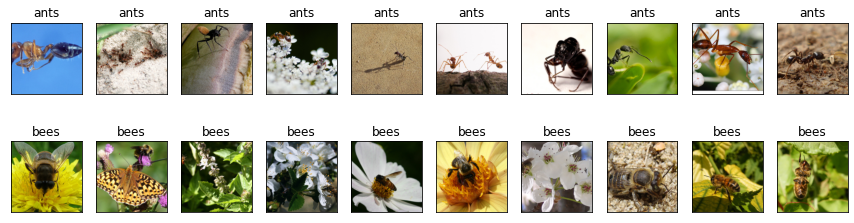

In [10]:
classes = ['ants', 'bees']

plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    image, label = trainval_dataset[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = trainval_dataset[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig("show.jpeg")
plt.show()

In [11]:
device = torch.device(parameter.DEVICE)

criterion = nn.CrossEntropyLoss()

In [16]:
def fit(net, optimizer, criterion, EPOCH, train_dataloader, val_dataloader, device, file_path):
    history = np.zeros((0,5))


    #loop of epoch
    for epoch in range(EPOCH):

        # training
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0


        #訓練フェーズ
        net.train()
        used_datasize = 0

        for inputs, labels in tqdm(train_dataloader):
            used_datasize += len(labels)    # 要確認
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            predicted = torch.max(outputs, 1)[1]
            train_acc += (predicted == labels).sum()
            avg_train_loss = train_loss / used_datasize
            avg_train_acc = train_acc / used_datasize


    # validation
    #予測フェーズ
    net.eval()
    used_datasize = 0

    for inputs, labels in val_dataloader:
        used_datasize += len(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)

        loss = criterion(outputs, labels)
        val_loss += loss.item()

        predicted = torch.max(outputs, 1)[1]

        val_acc += (predicted == labels).sum()

        avg_val_loss = val_loss / used_datasize
        avg_val_acc = val_acc / used_datasize


    dt_now = datetime.datetime.now()    #jstに設定しなおす。
    epoch_time = dt_now.strftime('%Y-%m-%d %H:%M:%S')
    #file_path = parameter.RESULT_DIR_PATH + "/" + parameter.EXPT_NUMBER + '.log'


    with open(file_path, 'a') as f:
        # print('Fold {}'.format(fold + 1), 'epoch', epoch, file=f)
        print(epoch_time, file=f)


        print (f'Epoch [{(epoch+1)}/{EPOCH}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}', file=f)
    item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
    history = np.vstack((history, item))

    return net, history[-1,3], history[-1,4], history

In [21]:
used_datasize

NameError: name 'used_datasize' is not defined

In [20]:
print(history[-1, 4])

tensor(0.5000, device='cuda:0')


In [17]:
nets, accs, losses = [], [], []

splits = KFold(n_splits=5, shuffle=True, random_state=26)   # random_stateの値は要検討
for fold, (train_idx, val_idx) in enumerate(splits.split(trainval_dataset)):
    file_path = parameter.RESULT_DIR_PATH + "/" + parameter.EXPT_NUMBER + '.log'
    with open(file_path, 'a') as f:
        print("model name: model", fold + 1, file=f)

    net = model.CNNs(p_dropout1=0, p_dropout2=0, use_Barch_Norm=False).to(device)
    optimizer = optim.SGD(net.parameters(),lr=parameter.LEARNING_RATE, momentum=0.9, weight_decay=parameter.WEIGHT_DECAY)   #Adams検討

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_dataloader = torch.utils.data.DataLoader(
        trainval_dataset, batch_size=parameter.TRAIN_BATCH_SIZE,
        sampler=train_sampler, num_workers=2, drop_last=True
    )
    val_dataloader = torch.utils.data.DataLoader(
        trainval_dataset, batch_size=parameter.TRAIN_BATCH_SIZE,
        sampler=val_sampler, num_workers=2, drop_last=True
    )

    net, loss, acc, history = fit(net, optimizer, criterion, parameter.EPOCH, train_dataloader, val_dataloader, device, file_path)
    nets.append(net)
    losses.append(loss)
    accs.append(float(acc))

    #graph.plot_loss_acc(history[:,1], history[:,2], history[:,3], history[:,4], fold)
    graph.evaluate_history(history, fold, parameter=Parameters1)

    model_path = parameter.RESULT_DIR_PATH  + '/model' + str(fold+1) + '.pth'
    torch.save(net.state_dict(), model_path)


with open(file_path, 'a') as f:
    print("oof loss: {:4f}".format(mean(losses)), file=f)
    print("oof acc: {:4f}".format(mean(accs)), file=f)



#show_images_labels(test_dataloader, classes, net, device)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

# ここまで

In [ ]:





# trainval_dataset = dataset.MyDataset(parameter.TRAIN_DATASET_PATH + "/train", (parameter.RESIZE[0], parameter.RESIZE[1]))    #画像のリサイズはいくらにするか？　これは学習とテストに影響を与える

#trainval_dataset = dataset.pytorch_book(parameter.TRAIN_DATASET_PATH)
'''
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])
train_dir = os.path.join(parameter.TRAIN_DATASET_PATH, 'train')
trainval_dataset = datasets.ImageFolder(train_dir,
                    transform=train_transform)
'''
classes = ['ants', 'bees']

plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    image, label = trainval_dataset[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = trainval_dataset[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig("show.jpeg")






## cross val
nets, accs, losses = [], [], []

splits = KFold(n_splits=5, shuffle=True, random_state=26)   # random_stateの値は要検討
for fold, (train_idx, val_idx) in enumerate(splits.split(trainval_dataset)):
    file_path = parameter.RESULT_DIR_PATH + "/" + parameter.EXPT_NUMBER + '.log'
    with open(file_path, 'a') as f:
        print("model name: model", fold + 1, file=f)

    net = model.CNNs(p_dropout1=0, p_dropout2=0, use_Barch_Norm=False).to(device)
    optimizer = optim.SGD(net.parameters(),lr=parameter.LEARNING_RATE, momentum=0.9, weight_decay=parameter.WEIGHT_DECAY)   #Adams検討

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_dataloader = torch.utils.data.DataLoader(
        trainval_dataset, batch_size=parameter.TRAIN_BATCH_SIZE,
        sampler=train_sampler, num_workers=2, drop_last=True
    )
    val_dataloader = torch.utils.data.DataLoader(
        trainval_dataset, batch_size=parameter.TRAIN_BATCH_SIZE,
        sampler=val_sampler, num_workers=2, drop_last=True
    )

    net, loss, acc, history = fit(net, optimizer, criterion, parameter.EPOCH, train_dataloader, val_dataloader, device, file_path)
    nets.append(net)
    losses.append(loss)
    accs.append(float(acc))

    #graph.plot_loss_acc(history[:,1], history[:,2], history[:,3], history[:,4], fold)
    graph.evaluate_history(history, fold, parameter=Parameters1)

    model_path = parameter.RESULT_DIR_PATH  + '/model' + str(fold+1) + '.pth'
    torch.save(net.state_dict(), model_path)


with open(file_path, 'a') as f:
    print("oof loss: {:4f}".format(mean(losses)), file=f)
    print("oof acc: {:4f}".format(mean(accs)), file=f)



#show_images_labels(test_dataloader, classes, net, device)




def fit(net, optimizer, criterion, EPOCH, train_dataloader, val_dataloader, device, file_path):
    history = np.zeros((0,5))


    #loop of epoch
    for epoch in range(EPOCH):

        # training
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0


        #訓練フェーズ
        net.train()
        used_datasize = 0

        for inputs, labels in tqdm(train_dataloader):
            used_datasize += len(labels)    # 要確認
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            predicted = torch.max(outputs, 1)[1]
            train_acc += (predicted == labels).sum()
            avg_train_loss = train_loss / used_datasize
            avg_train_acc = train_acc / used_datasize


    # validation
    #予測フェーズ
    net.eval()
    used_datasize = 0

    for inputs, labels in val_dataloader:
        used_datasize += len(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)

        loss = criterion(outputs, labels)
        val_loss += loss.item()

        predicted = torch.max(outputs, 1)[1]

        val_acc += (predicted == labels).sum()

        avg_val_loss = val_loss / used_datasize
        avg_val_acc = val_acc / used_datasize


    dt_now = datetime.datetime.now()    #jstに設定しなおす。
    epoch_time = dt_now.strftime('%Y-%m-%d %H:%M:%S')
    #file_path = parameter.RESULT_DIR_PATH + "/" + parameter.EXPT_NUMBER + '.log'


    '''
    with open(file_path, 'a') as f:
    print("train mean loss={}, accuracy={}".format(
        train_loss*TRAIN_BATCH_SIZE/len(train_dataloader.dataset), float(train_sum_correct/train_sum_total)), file=f)  #lossとaccuracy出力 ここのグラフの出力を確認する！！！
    train_loss_value.append(train_loss*TRAIN_BATCH_SIZE/len(train_dataloader.dataset))  #traindataのlossをグラフ描画のためにlistに保持
    train_acc_value.append(float(train_sum_correct/train_sum_total))   #traindataのaccuracyをグラフ描画のためにlistに保持

    print("val mean loss={}, accuracy={}".format(
        val_sum_loss*TRAIN_BATCH_SIZE/len(val_dataloader.dataset), float(val_sum_correct/val_sum_total)), file=f)  #lossとaccuracy出力
    val_loss_value.append(val_sum_loss*TRAIN_BATCH_SIZE/len(val_dataloader.dataset))  #traindataのlossをグラフ描画のためにlistに保持 open内に書かなくてよい
    val_acc_value.append(float(val_sum_correct/val_sum_total))   #traindataのaccuracyをグラフ描画のためにlistに保持

    '''


    with open(file_path, 'a') as f:
        # print('Fold {}'.format(fold + 1), 'epoch', epoch, file=f)
        print(epoch_time, file=f)


        print (f'Epoch [{(epoch+1)}/{EPOCH}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}', file=f)
    item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
    history = np.vstack((history, item))

return net, history[-1,3], history[-1,4], history






if __name__ == "__main__":
learning(parameter=Parameters1)
# イメージとラベル表示

In [8]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y-%m-%d %H:%M:%S')
print(now)

2021-12-24 19:21:27


In [1]:
results = {
    'a': ['apple', 'alpha'],
    'b': ['banana', 'beta'],
    'o': ['orange'],
}

In [13]:
results["a"][0]

'apple'

In [8]:
import itertools

parameter_list = itertools.product(
    results["a"],
    results["b"],
    results["o"],
)

In [9]:
print(parameter_list)

In [10]:
for idx, parameter_change in enumerate(parameter_list):
    print("condition: ", str(idx), parameter_change)


condition:  0 ('apple', 'banana', 'orange')
condition:  1 ('apple', 'beta', 'orange')
condition:  2 ('alpha', 'banana', 'orange')
condition:  3 ('alpha', 'beta', 'orange')


In [12]:
print(parameter_change[0])

alpha


In [ ]:
parameter_change_key = ['data']

In [ ]:
use_parameter_dict_key = ['optimizer', 'weight_decay', 'lr']
    

In [ ]:
for i in len(u)

In [16]:
import itertools


parameter_dict = {
    'dataset': ['my_dataset', 'image_folder'],
    'optimizer': ['adam', 'sgd'],
    'weight_decay': [0.01, 0.005, 0.001,],
    'lr': [ 0.0005, 0.0001, 0.00005,],
}
use_parameter_dict_key = ['optimizer', 'weight_decay', 'lr']
para_list = []
for i in range(len(use_parameter_dict_key)):
    para_list.append(parameter_dict[use_parameter_dict_key[i]])



In [17]:
para_list

[['adam', 'sgd'], [0.01, 0.005, 0.001], [0.0005, 0.0001, 5e-05]]

In [22]:
parameter_list = itertools.product(
    *para_list
)

print(parameter_list)

In [23]:
for idx, parameter_change in enumerate(parameter_list):
        print("####################")
        print("####################")
        print("condition: ", str(idx), parameter_change)


####################
####################
condition:  0 ('adam', 0.01, 0.0005)
####################
####################
condition:  1 ('adam', 0.01, 0.0001)
####################
####################
condition:  2 ('adam', 0.01, 5e-05)
####################
####################
condition:  3 ('adam', 0.005, 0.0005)
####################
####################
condition:  4 ('adam', 0.005, 0.0001)
####################
####################
condition:  5 ('adam', 0.005, 5e-05)
####################
####################
condition:  6 ('adam', 0.001, 0.0005)
####################
####################
condition:  7 ('adam', 0.001, 0.0001)
####################
####################
condition:  8 ('adam', 0.001, 5e-05)
####################
####################
condition:  9 ('sgd', 0.01, 0.0005)
####################
####################
condition:  10 ('sgd', 0.01, 0.0001)
####################
####################
condition:  11 ('sgd', 0.01, 5e-05)
####################
####################
condition

In [24]:
parameter_change_dict = dict(zip(use_parameter_dict_key, parameter_change))

In [25]:
parameter_change_dict

{'optimizer': 'sgd', 'weight_decay': 0.001, 'lr': 5e-05}

In [26]:
parameter_change_dict['dataset']

KeyError: 'dataset'

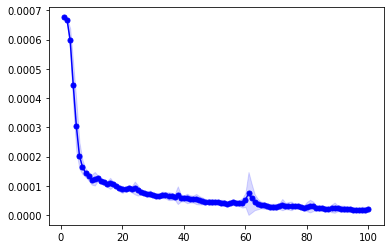

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

header_name = ('epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc')
header_name_fold = ('fold1', 'fold2', 'fold3', 'fold4', 'fold5')

df_fold1 = pd.read_csv('/home/megu/ECoG_CNNs/Result/2022-01-07_Base_Line/history_fold1.csv',
                names=header_name)
df_fold2 = pd.read_csv('/home/megu/ECoG_CNNs/Result/2022-01-07_Base_Line/history_fold2.csv',
                names=header_name)
df_fold3 = pd.read_csv('/home/megu/ECoG_CNNs/Result/2022-01-07_Base_Line/history_fold3.csv',
                names=header_name)
df_fold4 = pd.read_csv('/home/megu/ECoG_CNNs/Result/2022-01-07_Base_Line/history_fold4.csv',
                names=header_name)
df_fold5 = pd.read_csv('/home/megu/ECoG_CNNs/Result/2022-01-07_Base_Line/history_fold5.csv',
                names=header_name)

df_train_loss = pd.concat([df_fold1['train_loss'], 
                df_fold2['train_loss'],
                df_fold3['train_loss'],
                df_fold4['train_loss'],
                df_fold5['train_loss']], axis=1,)
df_train_loss.columns = header_name_fold

df_train_acc = pd.concat([df_fold1['train_acc'], 
                df_fold2['train_acc'],
                df_fold3['train_acc'],
                df_fold4['train_acc'],
                df_fold5['train_acc']], axis=1,)
df_train_acc.columns = header_name_fold
np_train_acc = df_train_acc.values

df_val_loss = pd.concat([df_fold1['val_loss'], 
                df_fold2['val_loss'],
                df_fold3['val_loss'],
                df_fold4['val_loss'],
                df_fold5['val_loss']], axis=1,)
df_val_loss.columns = header_name_fold
np_val_loss = df_val_loss.values

df_val_acc = pd.concat([df_fold1['val_acc'], 
                df_fold2['val_acc'],
                df_fold3['val_acc'],
                df_fold4['val_acc'],
                df_fold5['val_acc']], axis=1,)
df_val_acc.columns = header_name_fold
np_val_acc = df_val_acc.values

df_train_loss_mean = df_train_loss.mean(axis=1)
df_train_loss_std = df_train_loss.std(axis=1)

np_train_loss_mean = df_train_loss_mean.values
np_train_loss_std = df_train_loss_std.values

train_loss_center = np_train_loss_mean
train_loss_high = np_train_loss_mean + np_train_loss_std
train_loss_low = np_train_loss_mean - np_train_loss_std

epoch = df_fold1['epoch'].values

plt.plot(epoch, train_loss_center, color='blue', marker='o', markersize=5, label='training score')
plt.fill_between(epoch, train_loss_high, train_loss_low, alpha=0.15, color='blue')
plt.show()

In [4]:
epoch = list(range(1, 101))
print(epoch)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


In [5]:
import numpy as np
np.arange(1, 101)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])